In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function

from collections import OrderedDict
import copy
from os.path import abspath, basename, join, isdir, isfile
from os import makedirs
import pickle
import sys
import time

import numpy as np
np.set_printoptions(edgeitems=30, linewidth=300)
import pandas as pd
from numba import vectorize

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline

from pisa.utils.flavInt import NuFlavIntGroup

from plotGoodies import hsvaFact

RETRO_DIR = abspath('..')
sys.path.append(RETRO_DIR)
from retro.const import (
    DC_ALL_STRS, DC_STRS, DC_IC_STRS, IC_STRS, IC_SUBDUST_DOMS, DC_SUBDUST_DOMS, IC_SUBDUST_DOMS,
    BEDROCK_DEPTH, I3_Z0_DEPTH,
    MUON_REST_MASS, NOMINAL_ICE_DENSITY,
)
from retro.utils.misc import expand, mkdir
from retro.muon_hypo import (
    TRACK_M_PER_GEV,
    const_muon_energy_to_length,
    const_muon_length_to_energy,
    ConstABModel,
    generate_const_a_b_converters,
    generate_gms_table_converters,
    generate_min_energy_fit_converters,
)
from retro.utils.geom import rotate_points, generate_digitizer
from retro.utils.get_retro_results import augment_info
from retro.utils.plot_all_distributions import plot_all_distributions
from retro.utils.lerp import generate_lerp

<< PISA is running in double precision (FP64) mode; numba is running on GPU >>


In [3]:
outdir = "muon_length_vs_energy"
mkdir(outdir)

In [4]:
!pwd

/home/justin/src/retro/notebooks


In [5]:
DC_SUBDUST_DOMS_MASK = np.array([(i in DC_SUBDUST_DOMS) for i in range(1, 61)])
IC_SUBDUST_DOMS_MASK = np.array([(i in IC_SUBDUST_DOMS) for i in range(1, 61)])
BEDROCK_Z = I3_Z0_DEPTH - BEDROCK_DEPTH

In [6]:
gcd = pickle.load(open('../data/GeoCalibDetectorStatus_2013.56429_V1_Modified.pkl', 'rb'))
geo = gcd['geo']

In [7]:
z = geo[DC_IC_STRS - 1, :, 2].T[IC_SUBDUST_DOMS_MASK]
z.min(), z.max()

(-510.57000732421875, 95.5999984741211)

In [8]:
z = geo[DC_STRS - 1, :, 2].T[DC_SUBDUST_DOMS_MASK]
dc_sd_zlims = z.min(), z.max()
dc_sd_zlims

(-505.4100036621094, -156.41000366210938)

In [9]:
true_mu_en_col = "truth_highest_energy_daughter_energy"
true_mu_len_col = "truth_highest_energy_daughter_length"
true_nu_en_col = "truth_energy"
true_cscd_en_col = "truth_cascade_energy"

In [10]:
def q0_mean_q1(x, q):
    if len(q) == 3:
        q = (q[0], q[2])
    qv = np.percentile(x, [qq*100 for qq in q])
    mn = np.nanmean(x)
    return (qv[0], mn, qv[1])

In [11]:
def binned_op(
    evts, op, op_col, num_bins=None,
    bin_edges=None, bin_indices=None, bin_col=None, digitizer=None,
    op_args=None, op_kwargs=None
):
    if op_args is None:
        op_args = ()

    if op_kwargs is None:
        op_kwargs = {}

    if bin_indices is None:
        if digitizer is None:
            digitizer = vectorize()(generate_digitizer(bin_edges))
            if num_bins is not None:
                assert num_bins == len(bin_edges) - 1
            num_bins = len(bin_edges) - 1
        bin_indices = digitizer(evts[bin_col].values)

    vals = evts[op_col].values

    op_vals = []
    for bin_idx in range(num_bins):
        mask = bin_indices == bin_idx
        try:
            val = op(vals[mask], *op_args, **op_kwargs)
        except:
            val = np.nan
            raise
        op_vals.append(val)

    return np.array(op_vals)

In [12]:
def filt_lr(x, y, order):
    y = np.copy(y)
    if order == 0:
        return y
    n = len(x)
    for i in range(order, n - order):
        dx = np.diff(x[i - order : i + order + 1])
        dy = np.diff(y[i - order : i + order + 1])
        m_avg = np.mean(dy / dx)
        y[i] = y[i - 1] + m_avg * np.sum(dx[:1])
    return y

def filt_rl(x, y, order):
    y = np.copy(y)
    if order == 0:
        return y
    n = len(x)
    for i in range(order, n - order)[::-1]:
        dx = np.diff(x[i - order : i + order + 1])
        dy = np.diff(y[i - order : i + order + 1])
        m_avg = np.mean(dy / dx)
        y[i] = y[i + 1] - m_avg * np.sum(dx[:1])
    return y

def filtfilt(x, y, order):
    if order == 0:
        return y
    y = filt_rl(x, y, order=order)
    y = filt_lr(x, y, order=order)
    return y

In [13]:
def fillnan_lr_rl(x):
    # Fill nan's from next value
    for i in range(1, len(x)):
        val = x[i]
        if np.isnan(val):
            x[i] = x[i + 1]
    # Fill nan's from previous value
    for i in range(len(x) - 1, -1, -1):
        val = x[i]
        if np.isnan(val):
            x[i] = x[i - 1]
    return x

def get_ascending_mask(y):
    lastval = y[0]
    mask = [True]
    for val in y[1:]:
        if val <= lastval:
            mask.append(False)
        else:
            lastval = val
            mask.append(True)
    return np.array(mask, dtype=bool)

In [14]:
def outl_rej(x):
    qv = np.percentile(x, q=(90, 99, 99.9))
    if (qv[-1] / qv[-2]) > (1 * qv[-2] / qv[-3]):
        #print('rej', x.min(), x.max())
        return qv[-3]
    return qv[-1]

In [15]:
def scatterplot(evts, name, nbins, nbins_final, order, ax=None):
    #evts = numu_cc ; ax = None
    true_mu_en = evts[true_mu_en_col].values
    true_mu_len = evts[true_mu_len_col].values

    sort_ind = np.argsort(true_mu_en)
    true_mu_en = true_mu_en[sort_ind]
    true_mu_len = true_mu_len[sort_ind]

    mask = (true_mu_en > 0) & (true_mu_len > 0) & (true_mu_len < 1e4)
    true_mu_en = true_mu_en[mask]
    true_mu_len = true_mu_len[mask]

    log10_en = np.log10(true_mu_en)
    log10_enlim = (log10_en.min(), log10_en.max())
    e_edges = np.logspace(log10_enlim[0], log10_enlim[1], nbins)
    num_e_edges = len(e_edges)
    num_e_bins = num_e_edges - 1
    e_dig = vectorize()(generate_digitizer(bin_edges=e_edges, clip=False))
    e_bin_indices = e_dig(true_mu_en)

    l_maxes = np.full(num_e_edges, fill_value=np.nan)
    # Populate lmaxes with right edge first since curve is monotonic-increasing
    # and max of bin values should be on ~ right side of the bin
    for idx in range(num_e_edges - 1, 0, -1):
        mask = e_bin_indices == idx
        if np.sum(mask) == 0:
            if idx == num_e_edges - 1:
                l_max = true_mu_len.max()
            else:
                l_max = l_maxes[idx + 1]
        else:
            l_max = np.max(true_mu_len[mask])
        l_maxes[idx] = l_max
    l_maxes[0] = true_mu_len.min()
    l_maxes = fillnan_lr_rl(l_maxes)
    log_l_maxes = np.log10(l_maxes)
    log_e_edges = np.log10(e_edges)

    spl = UnivariateSpline(x=log_e_edges, y=log_l_maxes, k=1, s=0)

    # do same process but swap axes & take min
    lsort_ind = np.argsort(true_mu_len)
    ltrue_mu_en = true_mu_en[lsort_ind]
    ltrue_mu_len = true_mu_len[lsort_ind]

    log10_len = np.log10(ltrue_mu_len)
    log10_lenlim = (log10_len.min(), log10_len.max())
    ledges = np.logspace(log10_lenlim[0], log10_lenlim[1], 1000)

    dig = vectorize()(generate_digitizer(ledges))
    nbins = len(ledges) - 1
    bin_indices = dig(ltrue_mu_len)

    emins = np.full_like(ledges, fill_value=np.nan)
    # Populate emins with left edge first since curve is monotonic-increasing
    # and min of bin values should be on ~ left side of the bin
    for idx in range(nbins):
        mask = bin_indices == idx
        if np.sum(mask) == 0:
            emin = emins[idx - 1]
        else:
            emin = np.min(ltrue_mu_en[mask])
        emins[idx] = emin
    emins[nbins] = ltrue_mu_en[-1]
    emins = fillnan_lr_rl(emins)
    log_emins = np.log10(emins)
    log_ledges = np.log10(ledges)
    #swapped_filtered = filtfilt(x=log_ledges, y=log_emins, order=1)

    #print(log_swapped_maxes[:10], log_swapped_maxes[-10:])
    asc_mask = get_ascending_mask(emins)
    swapped_spl = UnivariateSpline(x=emins[asc_mask], y=log_ledges[asc_mask], k=1, s=0)
    new_log_e_edges = np.linspace(log_e_edges.min(), log_e_edges.max(), nbins_final)
    y1 = spl(new_log_e_edges)
    y2 = swapped_spl(new_log_e_edges)

    # use max since E is on x-axis and len is y-axis
    #y3 = np.max([y1, y2], axis=0)
    y3 = y1

    y3_smoothed = filtfilt(x=new_log_e_edges, y=y3, order=order)
    asc_mask = get_ascending_mask(y3_smoothed)

    new_spl = UnivariateSpline(x=new_log_e_edges[asc_mask], y=y3_smoothed[asc_mask], k=1, s=0)
    y3_smoothed = new_spl(new_log_e_edges)

    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    else:
        fig = ax.get_figure()

    ax.plot(true_mu_en, true_mu_len, 'o', ms=2, mfc='g', mew=0, label='truth')
    ax.plot(10**new_log_e_edges, 10**new_spl(new_log_e_edges), '-', lw=0.5, c='k', label='smoothed(max(truth))')
    #ax.plot(edges[1:], maxes, 'o-', c='k', lw=0.5, ms=1, label='max truth')
    #ax.plot(true_mu_en, evts["ionization_mu_len"].values[sort_ind], lw=1, c='C7', label='GMS table, ionization only')
    #ax.plot(true_mu_en, evts["const_mu_len"].values[sort_ind], lw=0.5, c='C0', label='constant ~{:.3f} m/GeV'.format(TRACK_M_PER_GEV))
    #ax.plot(true_mu_en, evts["mmc3_mu_len"].values[sort_ind], lw=0.5, c='C1', label='MMC param, table 3')
    #ax.plot(true_mu_en, evts["mmc4_mu_len"].values[sort_ind], lw=0.5, c='C2', label='MMC param, table 4')
    #ax.plot(true_mu_en, evts["leera2_mu_len"].values[sort_ind], lw=0.5, c='C4', label='LEERA2 param')
    #ax.plot(true_mu_en, evts["proposal_mu_len"].values[sort_ind], lw=0.5, c='C5', label='PROPOSAL param')
    ax.plot(evts[true_mu_en_col].values[sort_ind], evts["table_mu_len"].values[sort_ind], lw=0.5, c='C3', label='GMS table')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.1, 1000)
    #ax.set_ylim(.1, 1e4)

    ax.legend(loc='best', fontsize=8)
    ax.set_xlabel('Muon energy (GeV)')
    ax.set_ylabel('Muon length in ice (m)')

    try:
        nfig = NuFlavIntGroup(name)
        title = '${}$'.format(nfig.tex) if nfig.tex else name
        name = str(nfig)
    except:
        title = name

    ax.set_title(title)

    #fpath = join(outdir, 'muon_length_vs_energy_{}'.format(name))
    #plt.savefig(fpath + '.png', dpi=300)
    #plt.savefig(fpath + '.pdf')

    return ax, e_edges, l_maxes, new_log_e_edges, y1, y2, y3, y3_smoothed

In [16]:
def plot_est_mu_en_error(
    evts,
    name,
    bin_edges,
    bin_col,
    xlim=None,
    ylim=None,
    alpha=0.2,
    ax=None,
    solid='mean',
    q=(0.25, 0.75),
    plot_constant=True,
    plot_mmc3=True,
    plot_mmc4=True,
    plot_leera2=True,
    plot_proposal=True,
    plot_table=True,
    plot_ionization=True,
    plot_min_en_env=True,
):
    if ax is None:
        fig, ax = plt.subplots(dpi=200)
        
    if xlim is None:
        xlim = np.min(bin_edges),  np.max(bin_edges)

    digitizer = vectorize()(generate_digitizer(bin_edges=bin_edges, clip=False))
    bin_indices = digitizer(evts[bin_col].values)

    if solid == 'median':
        op = np.percentile
        op_kwargs = dict(q=(q[0]*100, 50, q[1]*100))
    elif solid == 'mean':
        op = q0_mean_q1
        op_kwargs = dict(q=q)
    else:
        raise ValueError(str(solid))

    kw = dict(
        evts=evts,
        bin_indices=bin_indices,
        num_bins=len(bin_edges) - 1,
        op=op,
        op_kwargs=op_kwargs,
    )
    bl_const = binned_op(op_col="const_mu_en_rat", **kw)
    bl_mmc3 = binned_op(op_col="mmc3_mu_en_rat", **kw)
    bl_mmc4 = binned_op(op_col="mmc4_mu_en_rat", **kw)
    bl_leera = binned_op(op_col="leera2_mu_en_rat", **kw)
    bl_proposal = binned_op(op_col="proposal_mu_en_rat", **kw)
    bl_table = binned_op(op_col="table_mu_en_rat", **kw)
    bl_ionization = binned_op(op_col="ionization_mu_en_rat", **kw)
    bl_maxenv = binned_op(op_col="maxenv_mu_en_rat", **kw)
    
    if ylim is None:
        ylim = (
            0.1*np.floor(10*np.min([x.min() for x in [bl_const, bl_mmc3, bl_mmc4, bl_table]])),
            0.1*np.ceil(10*np.max([x.max() for x in [bl_const, bl_mmc3, bl_mmc4, bl_table]]))
        )

    if plot_constant:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_const[0, 0]] + bl_const[:, 0].tolist(),
            y2=[bl_const[0, 0]] + bl_const[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C0', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_const[0, 1]] + bl_const[:, 1].tolist(),
            label='constant ~{:.3f} m/GeV'.format(TRACK_M_PER_GEV),
            lw=1,
            color='C0',
        )
    if plot_mmc3:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_mmc3[0, 0]] + bl_mmc3[:, 0].tolist(),
            y2=[bl_mmc3[0, 0]] + bl_mmc3[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C1', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_mmc3[0, 1]] + bl_mmc3[:, 1].tolist(),
            label='MMC param, table 3',
            lw=1,
            color='C1',
        )
    if plot_mmc4:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_mmc4[0, 0]] + bl_mmc4[:, 0].tolist(),
            y2=[bl_mmc4[0, 0]] + bl_mmc4[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C2', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_mmc4[0, 1]] + bl_mmc4[:, 1].tolist(),
            label='MMC param, table 4',
            lw=1,
            color='C2',
        )
    if plot_leera2:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_leera[0, 0]] + bl_leera[:, 0].tolist(),
            y2=[bl_leera[0, 0]] + bl_leera[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C4', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_leera[0, 1]] + bl_leera[:, 1].tolist(),
            label='LEERA2 param',
            lw=1,
            color='C4',
        )
    if plot_proposal:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_proposal[0, 0]] + bl_proposal[:, 0].tolist(),
            y2=[bl_proposal[0, 0]] + bl_proposal[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C5', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_proposal[0, 1]] + bl_proposal[:, 1].tolist(),
            label='PROPOSAL param',
            lw=1,
            color='C5',
        )
    if plot_table:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_table[0, 0]] + bl_table[:, 0].tolist(),
            y2=[bl_table[0, 0]] + bl_table[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C3', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_table[0, 1]] + bl_table[:, 1].tolist(),
            label='GMS table',
            lw=1,
            color='C3',
        )
    if plot_ionization:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_ionization[0, 0]] + bl_ionization[:, 0].tolist(),
            y2=[bl_ionization[0, 0]] + bl_ionization[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C7', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_ionization[0, 1]] + bl_ionization[:, 1].tolist(),
            label='GMS table, ionization only',
            lw=1,
            color='C7',
        )
    if plot_min_en_env:
        ax.fill_between(
            x=bin_edges,
            y1=[bl_maxenv[0, 0]] + bl_maxenv[:, 0].tolist(),
            y2=[bl_maxenv[0, 0]] + bl_maxenv[:, 2].tolist(),
            step='pre',
            color=hsvaFact('C7', af=alpha),
        )
        ax.step(
            bin_edges,
            [bl_maxenv[0, 1]] + bl_maxenv[:, 1].tolist(),
            label='Min-energy envelope',
            lw=1,
            color='C8',
        )

    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_yticks(np.arange(0, 2.01, 0.1))
    ax.set_yticks(np.arange(.05, 2, 0.1), minor=True)
    ylabels = []
    for tickpos in ax.get_yticks():
        delta = tickpos - 1
        if delta == 0:
            lab = "0"
        else:
            lab = '{:+.0f}'.format(delta * 100)
        ylabels.append(lab)
    ax.set_yticklabels(ylabels)
    ax.grid(True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.yaxis.set_ticks_position('both')

    leg = ax.legend(
        loc='best',
        fontsize=8,
        title='{} (solid line) &\n{:.0f}% interquartile range (shaded region)'.format(
            solid.capitalize(),
            (q[1] - q[0])*100
        ),
    )
    title = leg.get_title()
    title.set_fontsize(6)

    ax.set_xlabel('True $\mu$ energy (GeV)')
    ax.set_ylabel(r'Estimated $\mu$ energy error (%)')
    
    try:
        nfig = NuFlavIntGroup(name)
        title = '${}$'.format(nfig.tex)
        name = str(nfig)
    except:
        title = name

    ax.set_title(title)

    return ax

# Generate depth -> density interpolator

In [17]:
dc_sd_zlims[0], dc_sd_zlims[1]

(-505.4100036621094, -156.41000366210938)

ice density in deepcore sub-dust-layer region: min = 0.91997, median = 0.92064, mean = 0.92062, max = 0.92121


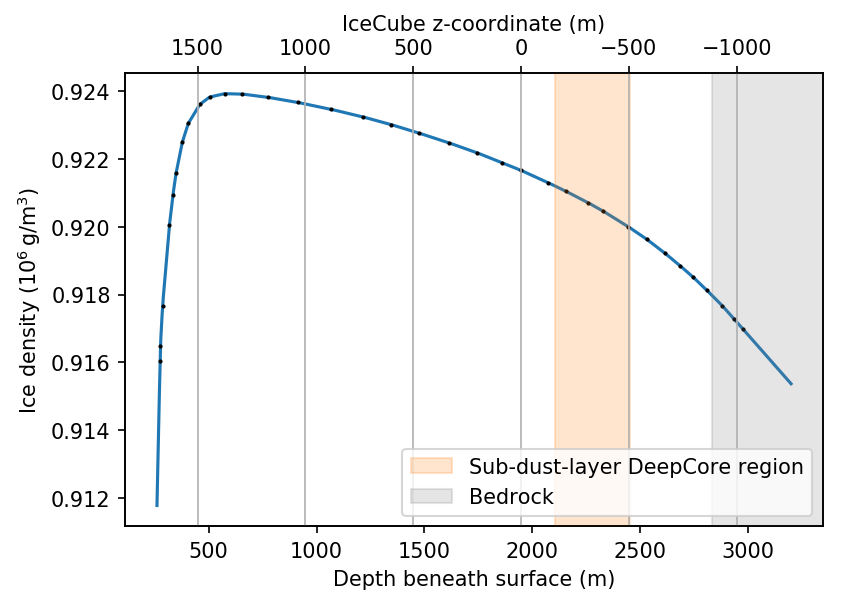

In [18]:
# data points extracted from
#   https://icecube.wisc.edu/~dima/work/WISC/ppc/spice/ppc/rho/a_3.gif
# manually using
#   https://apps.automeris.io/wpd/
depth_density = """
274.44336882865446, 0.9160389822381778
275.8954501452081, 0.9164678196323822
286.0600193610843, 0.917675324025042
318.0058083252661, 0.9200564551614892
333.9787028073573, 0.9209366759021265
348.4995159728942, 0.92157990877834
377.5411423039693, 0.9224939607376634
405.1306873184899, 0.9230468869015286
458.85769603097765, 0.9236110491704778
503.87221684414317, 0.9238253845663633
573.572120038722, 0.9239268208674859
656.3407550822847, 0.9239153799233447
775.4114230396904, 0.9238192312010852
914.811229428848, 0.9236666179099133
1068.7318489835432, 0.9234631936078076
1213.939980638916, 0.92324285779314
1344.6272991287512, 0.9230169066571177
1475.314617618587, 0.9227627423549513
1611.8102613746369, 0.9224803539618909
1742.4975798644728, 0.9221866912271226
1858.664085188771, 0.9218930558042285
1948.693126815102, 0.9216615385082255
2073.5721200387225, 0.9213001750994608
2154.8886737657313, 0.9210517462908958
2259.4385285575995, 0.9207073490184416
2329.1384317521783, 0.9204589420593761
2445.3049370764766, 0.9200016702728457
2532.4298160697003, 0.9196234499752677
2613.746369796709, 0.9192283127027528
2686.3504356243952, 0.9188444770838202
2747.3378509196514, 0.9185058043802178
2808.325266214908, 0.9181332758772422
2880.9293320425945, 0.9176704433931059
2934.6563407550825, 0.91728664327961
2976.7666989351405, 0.9169818618808171
"""

depth_density = depth_density.strip().split('\n')
depth_density = np.array([[float(x) for x in l.split(', ')] for l in depth_density])
#print(depth_density[:5, :], depth_density[-5:, :])
_, dens_lerp = generate_lerp(
    x=depth_density[:, 0],
    y=depth_density[:, 1],
    low_behavior="extrapolate",
    high_behavior="extrapolate",
)

def dens_correction(depth):
    actual_density = dens_lerp(depth)
    return actual_density / NOMINAL_ICE_DENSITY

fig, ax = plt.subplots(dpi=150)
depths = np.linspace(260, 3200, 500)
ax.plot(depths, dens_lerp(depths))
ax.plot(depth_density[:, 0], depth_density[:, 1], 'ko', ms=1)
ax.set_xlabel(r'Depth beneath surface (m)')
ax.set_ylabel(r'Ice density $({10^6 \, \rm g / m^3})$')

ax2 = ax.twiny()
xlim = np.array([I3_Z0_DEPTH - x for x in ax.get_xlim()])
ylim = ax.get_ylim()
ax2.fill_betweenx(
    y=ylim,
    x1=dc_sd_zlims[0],
    x2=dc_sd_zlims[1],
    color=hsvaFact('C1', af=0.2),
    zorder=-2,
    label='Sub-dust-layer DeepCore region',
)
ax2.fill_betweenx(
    y=ylim,
    x1=xlim[1],
    x2=BEDROCK_Z,
    color=hsvaFact('C7', af=0.2),
    zorder=-2,
    label='Bedrock',
)
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_xlabel('IceCube z-coordinate (m)')
ax2.grid(b=True, which='major')
ax2.legend(loc='lower right')

zz = np.linspace(dc_sd_zlims[0], dc_sd_zlims[1], 1000)
dd = I3_Z0_DEPTH - zz
rhorho = dens_lerp(dd)
print(
    'ice density in deepcore sub-dust-layer region: min = {:.5f}, median = {:.5f}, mean = {:.5f}, max = {:.5f}'
    .format(np.min(rhorho), np.median(rhorho), np.mean(rhorho), np.max(rhorho))
)

outfbase = join(outdir, 'density_vs_depth')
fig.savefig(outfbase + '.png', dpi=120)
fig.savefig(outfbase + '.pdf')

# Load events

In [19]:
p_evts = pickle.load(file('/home/peller/retro/notebooks/level5pt_merged.pkl', 'rb'))
wts = pickle.load(file('/data/icecube/retro/retro_dragonl5p_weights.pkl', 'rb'))
p_evts['weights'] = wts
augment_info(p_evts)
retro_cols = [c for c in p_evts.columns if 'retro' in c]
wtd_mean_cols = [c for c in retro_cols if 'weighted_mean' in c]
p_evts["truth_highest_energy_daughter_zmid"] = p_evts.truth_z + p_evts.truth_highest_energy_daughter_length/2 * p_evts.truth_highest_energy_daughter_coszen
p_evts["truth_highest_energy_daughter_zend"] = p_evts.truth_z + p_evts.truth_highest_energy_daughter_length * p_evts.truth_highest_energy_daughter_coszen
endpoints_z = p_evts[["truth_z", "truth_highest_energy_daughter_zend"]].values
p_evts["truth_highest_energy_daughter_max_depth"] = I3_Z0_DEPTH - endpoints_z.min(axis=1)
p_evts["truth_highest_energy_daughter_zmid_depth"] = I3_Z0_DEPTH - p_evts["truth_highest_energy_daughter_zmid"]

skipping "pegleg_angle_error"


In [20]:
p_evts.truth_z.describe()

count    1.327226e+06
mean    -3.562347e+02
std      7.583096e+01
min     -1.124970e+03
25%     -4.136375e+02
50%     -3.604248e+02
75%     -3.005150e+02
max      2.462804e+02
Name: truth_z, dtype: float64

In [21]:
p_evts.truth_highest_energy_daughter_max_depth.describe()

count    1.327226e+06
mean     2.320838e+03
std      1.393842e+02
min      1.701790e+03
25%      2.260074e+03
50%      2.320100e+03
75%      2.377936e+03
max      1.027368e+05
Name: truth_highest_energy_daughter_max_depth, dtype: float64

In [22]:
p_evts.retro_z_weighted_mean.describe()

count    1.327226e+06
mean    -3.545060e+02
std      7.431338e+01
min     -1.954749e+03
25%     -4.124068e+02
50%     -3.595398e+02
75%     -2.994017e+02
max      2.044412e+03
Name: retro_z_weighted_mean, dtype: float64

# Convert length $\leftrightarrow$ energy using various techniques

In [23]:
for model in list(ConstABModel):
    muon_energy_to_length, muon_length_to_energy = generate_const_a_b_converters(model=model)
    name = model.name
    mu_len = p_evts["{}_mu_len".format(name)] = muon_energy_to_length(p_evts[true_mu_en_col])
    mu_en = p_evts["{}_mu_en".format(name)] = muon_length_to_energy(p_evts[true_mu_len_col])
    p_evts["{}_mu_en_rat".format(name)] = mu_en / p_evts[true_mu_en_col]
    p_evts["{}_mu_len_rat".format(name)] = mu_len / p_evts[true_mu_len_col]

table_muon_energy_to_length, table_muon_length_to_energy, table_energy_bounds = generate_gms_table_converters(losses="all")
ionization_muon_energy_to_length, ionization_muon_length_to_energy, ionization_energy_bounds = generate_gms_table_converters(losses="ionization")
maxenv_muon_energy_to_length, maxenv_muon_length_to_energy, maxenv_energy_bounds = generate_min_energy_fit_converters()

In [24]:
table_length_bounds = table_muon_energy_to_length(np.array(table_energy_bounds))
table_energy_bounds, table_length_bounds

((0.11565837, 100000.10565837), array([7.63615824e-03, 1.55112859e+04]))

In [25]:
dcf = dens_correction(p_evts.truth_highest_energy_daughter_zmid_depth.values)
dcf.min(), dcf.max()

(0.6069433366573986, 1.002391227447693)

In [26]:
p_evts["const_mu_len"] = const_muon_energy_to_length(p_evts[true_mu_en_col])
p_evts["const_mu_en"] = const_muon_length_to_energy(p_evts[true_mu_len_col])
p_evts["const_mu_en_rat"] = p_evts["const_mu_en"] / p_evts[true_mu_en_col]
p_evts["const_mu_len_rat"] = p_evts["const_mu_len"] / p_evts[true_mu_len_col]

p_evts["table_mu_len"] = table_muon_energy_to_length(p_evts[true_mu_en_col].values) / dcf
p_evts["table_mu_en"] = table_muon_length_to_energy(p_evts[true_mu_len_col].values) * dcf
p_evts["table_mu_en_rat"] = p_evts["table_mu_en"] / p_evts[true_mu_en_col]
p_evts["table_mu_len_rat"] = p_evts["table_mu_len"] / p_evts[true_mu_len_col]

p_evts["ionization_mu_len"] = ionization_muon_energy_to_length(p_evts[true_mu_en_col].values)
p_evts["ionization_mu_en"] = ionization_muon_length_to_energy(p_evts[true_mu_len_col].values)
p_evts["ionization_mu_en_rat"] = p_evts["ionization_mu_en"] / p_evts[true_mu_en_col]
p_evts["ionization_mu_len_rat"] = p_evts["ionization_mu_len"] / p_evts[true_mu_len_col]

In [27]:
p_evts["maxenv_mu_len"] = maxenv_muon_energy_to_length(p_evts[true_mu_en_col].values)
p_evts["maxenv_mu_en"] = maxenv_muon_length_to_energy(p_evts[true_mu_len_col].values)
p_evts["maxenv_mu_en_rat"] = p_evts["maxenv_mu_en"] / p_evts[true_mu_en_col]
p_evts["maxenv_mu_len_rat"] = p_evts["maxenv_mu_len"] / p_evts[true_mu_len_col]

## Group events by flavor/interaction type

In [28]:
valid = p_evts.query('{} < 1e4'.format(true_mu_len_col))
cc = valid.query('InteractionType == 1')
nc = valid.query('InteractionType == 2')

nue_nuebar_cc = cc.query('abs(pdg) == 12')
numu_cc = cc.query('(pdg == 14)')
numubar_cc = cc.query('(pdg == -14)')
numu_numubar_cc = cc.query('abs(pdg) == 14')
nutau_nutaubar_cc = cc.query('(abs(pdg) == 16)')
nuall_nuallbar_nc = nc

flavgroups = OrderedDict([
    ('nue_cc+nuebar_cc', nue_nuebar_cc),
    ('numu_cc+numubar_cc', numu_numubar_cc),
    #('numu_cc', numu_cc),
    #('numubar_cc', numubar_cc),
    ('nutau_cc+nutaubar_cc', nutau_nutaubar_cc),
    ('nuall_nc+nuallbar_nc', nuall_nuallbar_nc),
])

# Plot the raw results

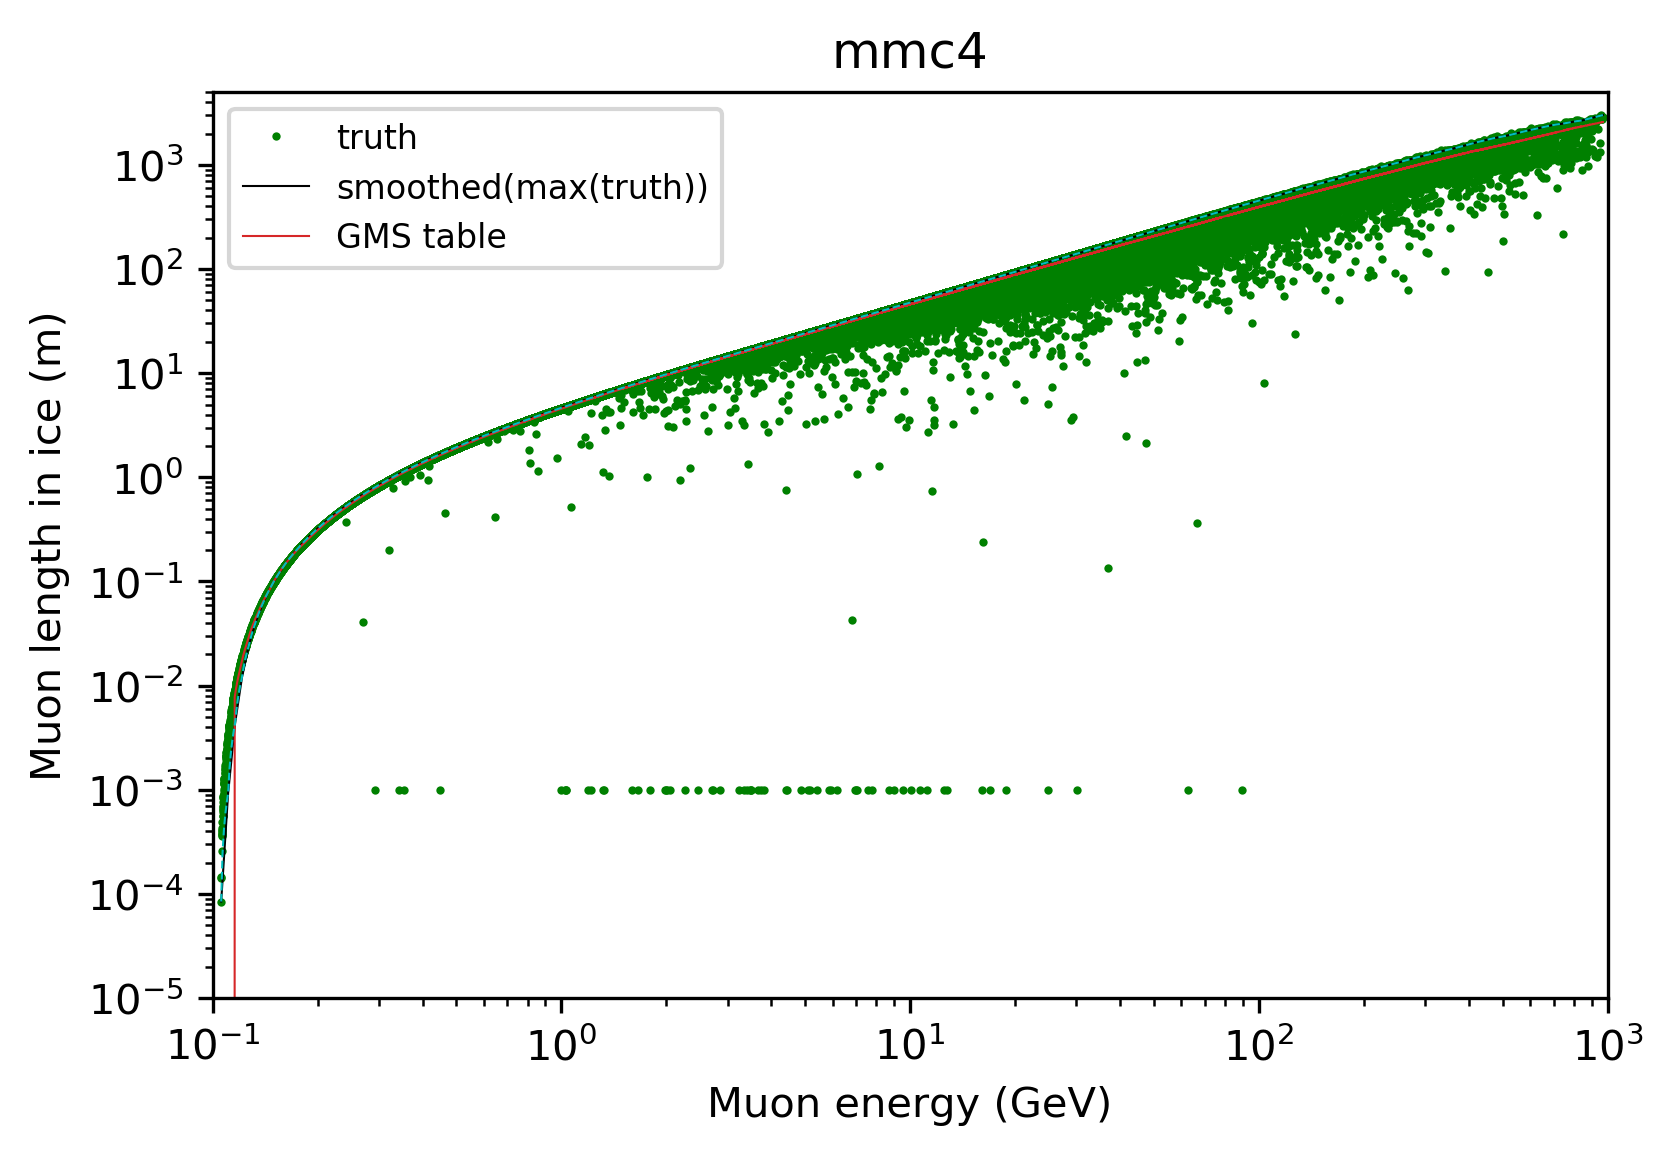

In [29]:
fig, ax = plt.subplots(dpi=300)
ax, e_edges, l_maxes, new_log_e_edges, y1, y2, y3, y3_smoothed = scatterplot(
    evts=flavgroups["numu_cc+numubar_cc"],
    name=name,
    ax=ax,
    nbins=500,
    nbins_final=200,
    order=1,
)
asc_mask = np.ones_like(y3_smoothed, dtype=bool) #get_ascending_mask(y3_smoothed)
_, maxenv_muon_energy_to_length = generate_lerp(
    x=10**new_log_e_edges[asc_mask],
    y=10**y3_smoothed[asc_mask],
    low_behavior='constant',
    high_behavior='extrapolate',
    low_val=0,
)
_, maxenv_muon_length_to_energy = generate_lerp(
    x=10**y3_smoothed[asc_mask],
    y=10**new_log_e_edges[asc_mask],
    low_behavior='constant',
    high_behavior='extrapolate',
    low_val=0,
)
x = np.logspace(np.log10(e_edges[0]), np.log10(e_edges[-1]), 1000)
ax.plot(x, maxenv_muon_energy_to_length(x), 'c--', lw=0.5)
ax.set_ylim(1e-5, 5e3)
# ax.set_xscale('linear')
# ax.set_yscale('linear')
en_len = np.array([10**new_log_e_edges, 10**y3_smoothed]).T
outfpath = join(outdir, "muon_min_energy_vs_len_fit.csv")
np.savetxt(X=en_len, fname=outfpath, delimiter=", ", header="energy (GeV), length (m)")

# Look at details of "max truth" line

(0.1, 1000.0)

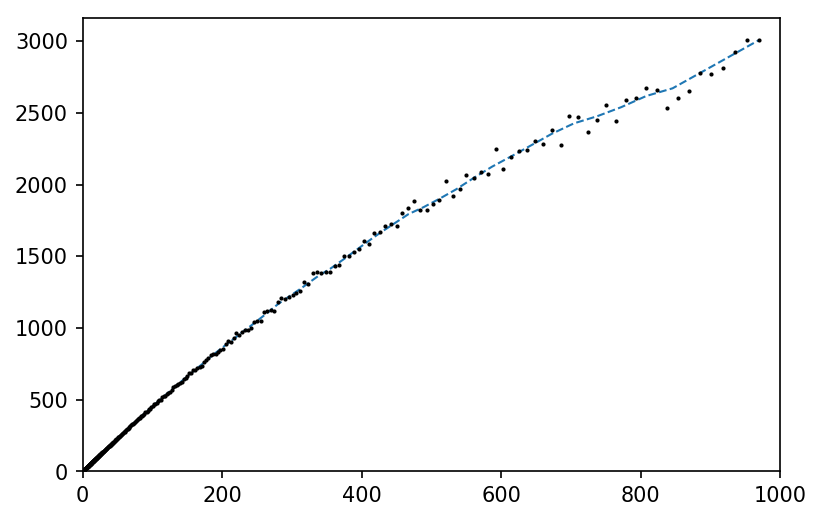

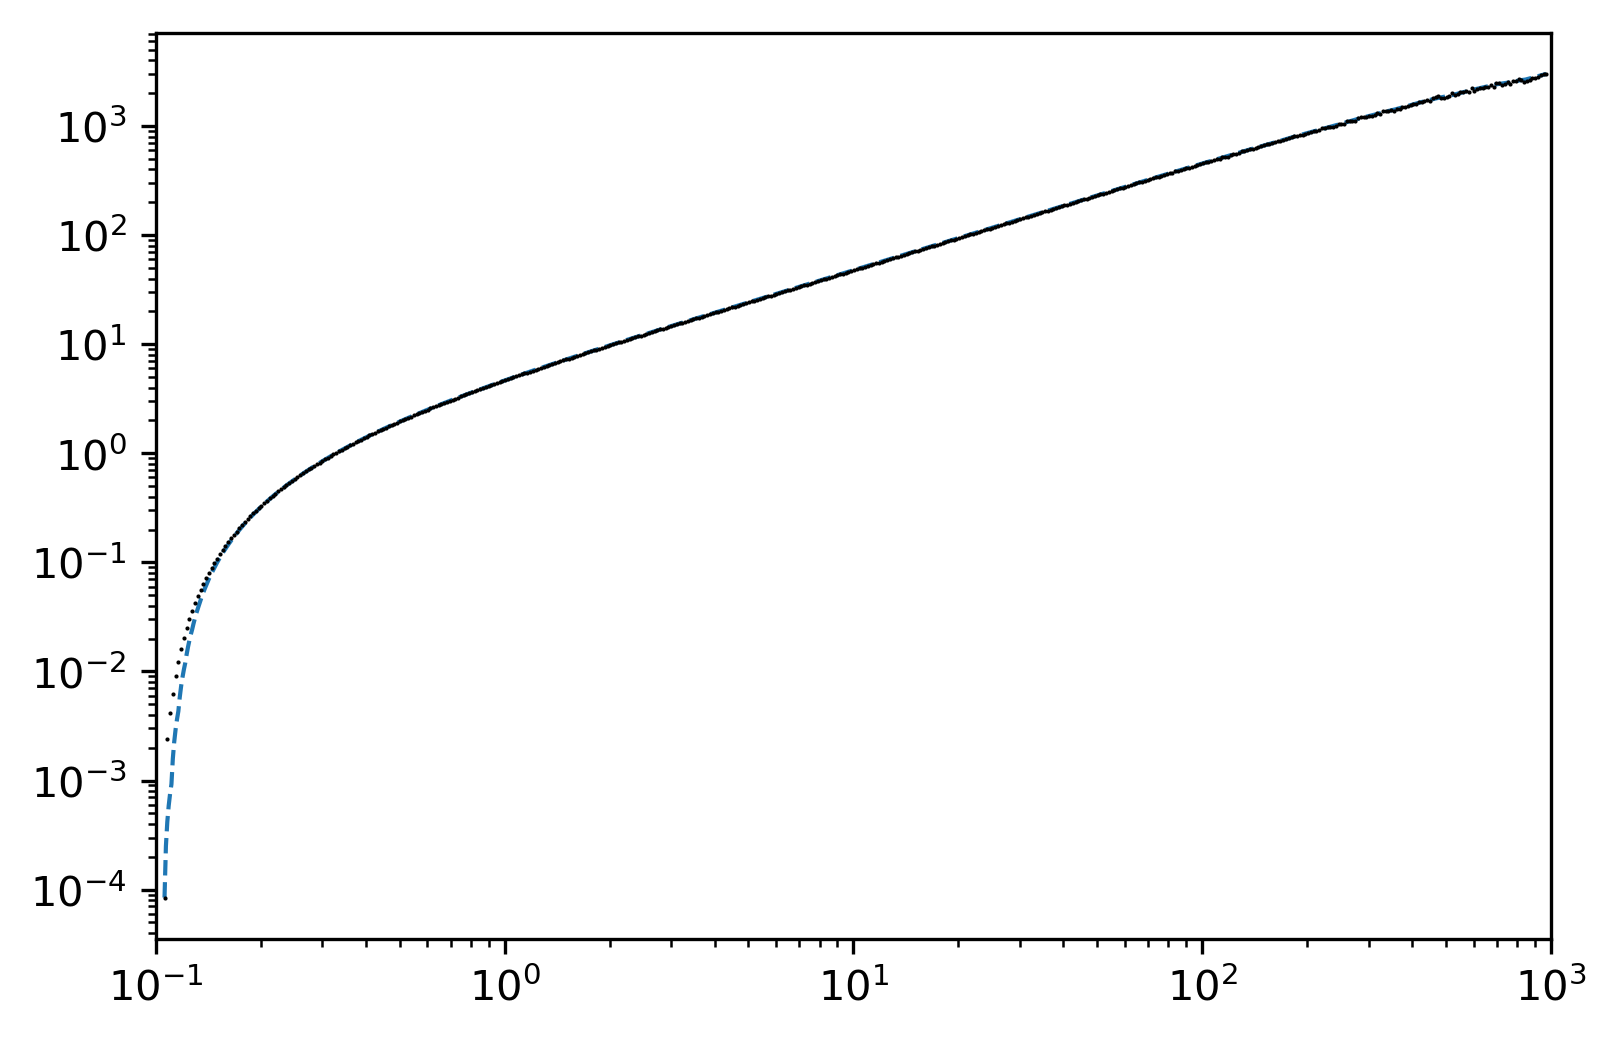

In [30]:
#print(edges[:20], maxes[:20])
log_edges = np.log10(e_edges)
samples_x = np.logspace(log_edges.min(), log_edges.max(), 1000)

fig, ax = plt.subplots(dpi=150)
#ax.plot(samples_x, 10**max_spl(np.log10(samples_x)), '-', lw=1)
ax.plot(samples_x, maxenv_muon_energy_to_length(samples_x), '--', lw=1)
ax.plot(e_edges, l_maxes, 'o', ms=2, mfc='k', mec='none', mew=0.5)
ax.set_xlim(0, 1e3)
ax.set_ylim(0, ax.get_ylim()[1])

fig, ax = plt.subplots(dpi=300)
#ax.plot(samples_x, 10**max_spl(np.log10(samples_x)), '-', lw=1)
ax.plot(samples_x, maxenv_muon_energy_to_length(samples_x), '--', lw=1)
ax.plot(e_edges, l_maxes, 'o', ms=1, mfc='k', mec='none', mew=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-1, 1e3)

# Plot estimated track energy error vs. true track energy

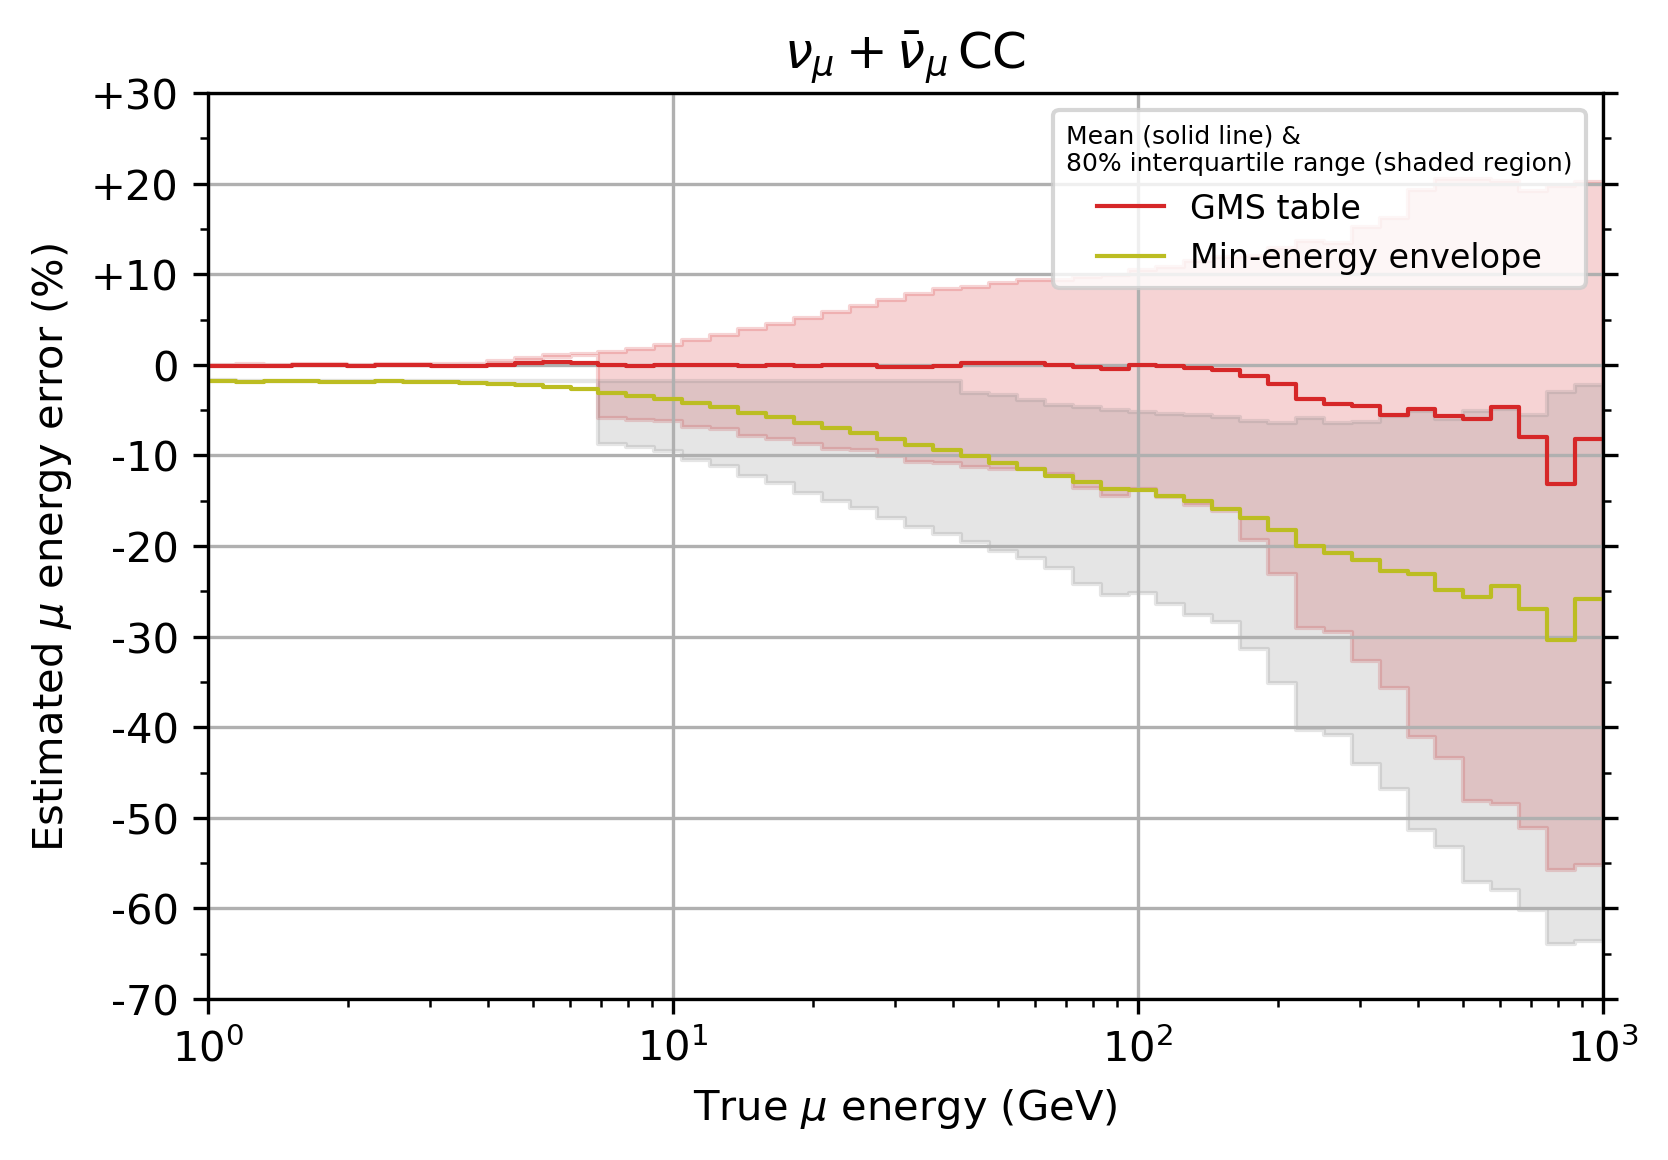

In [31]:
ebin_edges = np.logspace(np.log10(1), np.log10(1000), 51)
for name, evts in flavgroups.items():
    if 'numu' not in name:
        continue
    fig, ax = plt.subplots(dpi=300)
    ax = plot_est_mu_en_error(
        evts=evts,
        name=name,
        bin_edges=ebin_edges,
        bin_col=true_mu_en_col,
        solid='mean',
        q=(0.1, 0.9),
        ax=ax,
        ylim=(0.3, 1.3),
        plot_constant=False,
        plot_mmc3=False,
        plot_mmc4=False,
        plot_proposal=False,
        plot_leera2=False,
        plot_table=True,
        plot_ionization=False,
        plot_min_en_env=True,
    )
    fig = ax.get_figure()
    fname = join(outdir, 'muon_energy_err_vs_true_muon_energy_{}'.format(name))
    fig.savefig(fname + '.png', dpi=120)
    fig.savefig(fname + '.pdf')

# Estimated track energy error vs. true track length

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in digitize

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in digitize



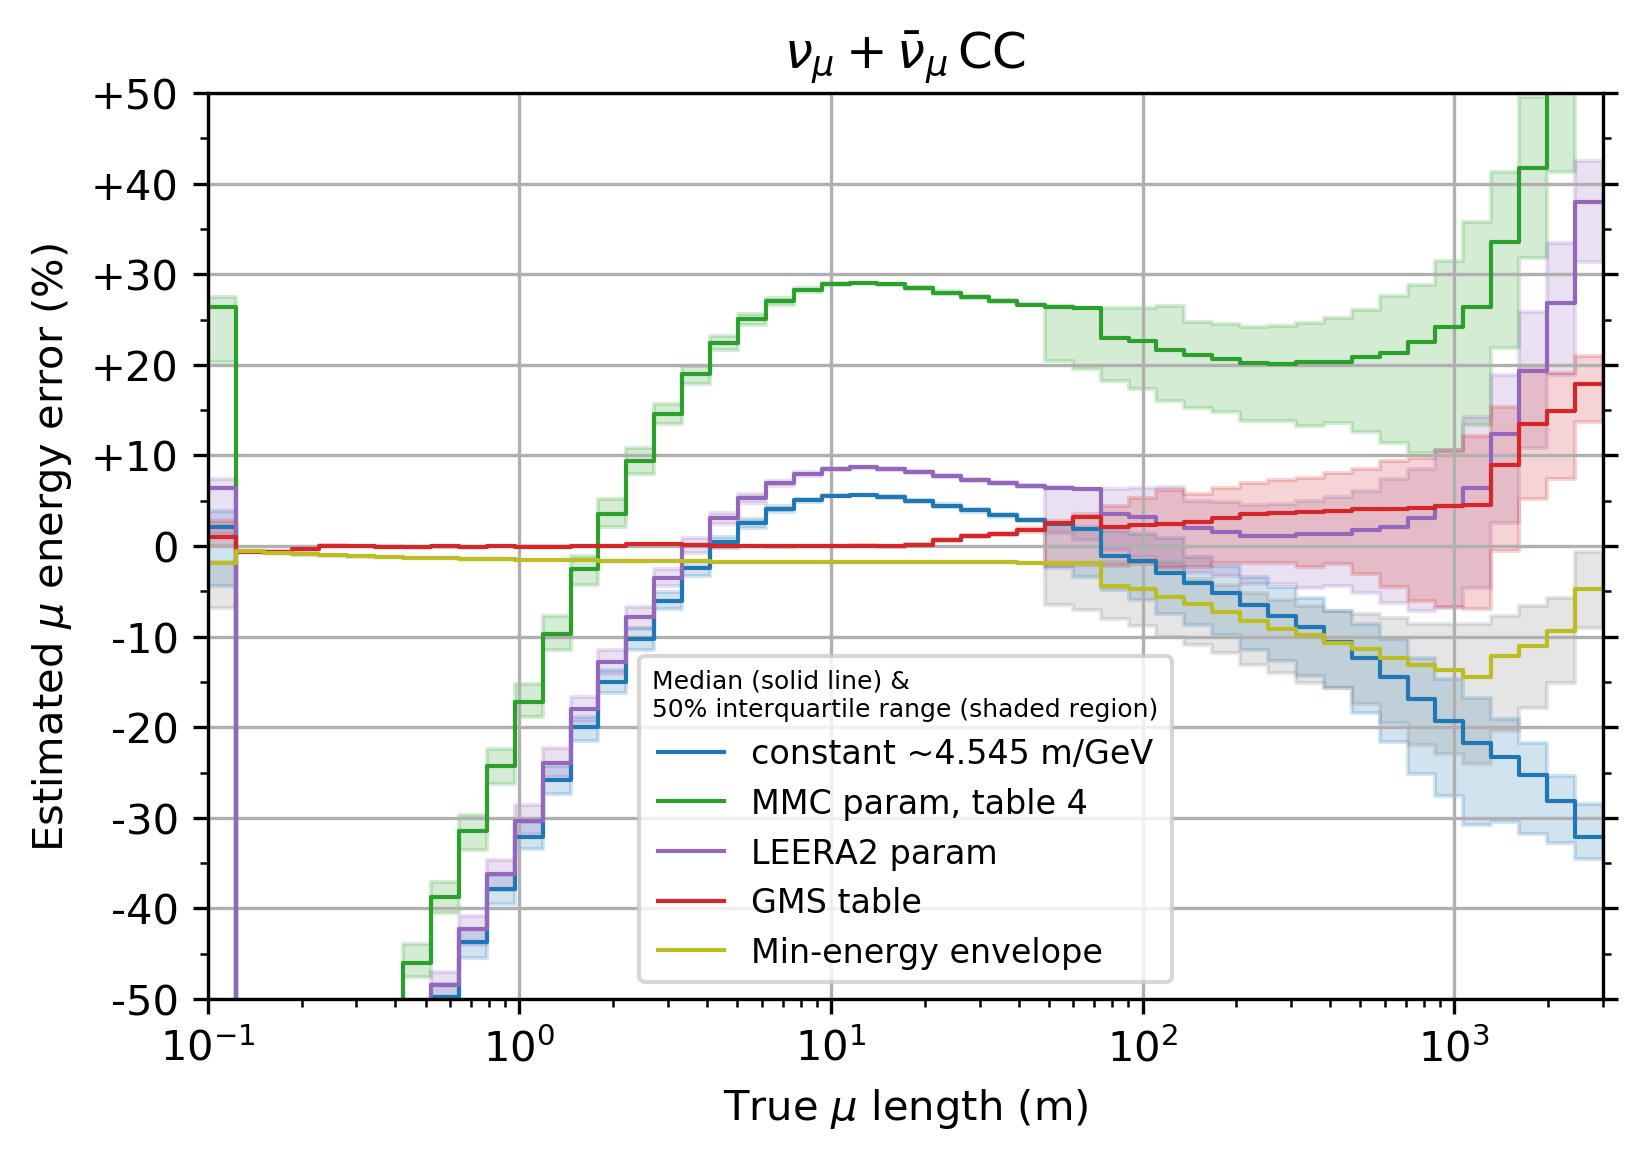

In [32]:
lbin_edges = np.logspace(np.log10(0.1), np.log10(3e3), 51)
for name, evts in flavgroups.items():
    if 'numu' not in name:
        continue
    fig, ax = plt.subplots(dpi=300)
    ax = plot_est_mu_en_error(
        evts=evts,
        name=name,
        bin_edges=lbin_edges,
        bin_col=true_mu_len_col,
        solid='median',
        ax=ax,
        ylim=(0.5, 1.5),
        plot_mmc3=False,
        plot_mmc4=True,
        plot_leera2=True,
        plot_proposal=False,
        plot_table=True,
        plot_ionization=False,
        plot_min_en_env=True,
    )
    ax.set_xlabel(r'True $\mu$ length (m)')
    fig = ax.get_figure()
    fname = join(outdir, 'muon_energy_err_vs_true_muon_length_{}'.format(name))
    fig.savefig(fname + '.png', dpi=120)
    fig.savefig(fname + '.pdf')

In [33]:
numu_cc = flavgroups["numu_cc+numubar_cc"]
numu_cc.truth_highest_energy_daughter_zmid_depth.describe()

count    821166.000000
mean       2315.062880
std          92.753103
min        1445.147698
25%        2253.845764
50%        2314.500099
75%        2372.248123
max        3641.364678
Name: truth_highest_energy_daughter_zmid_depth, dtype: float64

In [34]:
ss = numu_cc.query('truth_highest_energy_daughter_energy > 1')

In [35]:
np.mean(ss.maxenv_mu_en.values / ss.truth_highest_energy_daughter_energy.values)

0.9459780299111329

In [36]:
mask = ss.maxenv_mu_en.values > ss.truth_highest_energy_daughter_energy.values
np.sum(mask) / mask.size

4.7285206947441245e-05

0.0007404105868971682
0.0


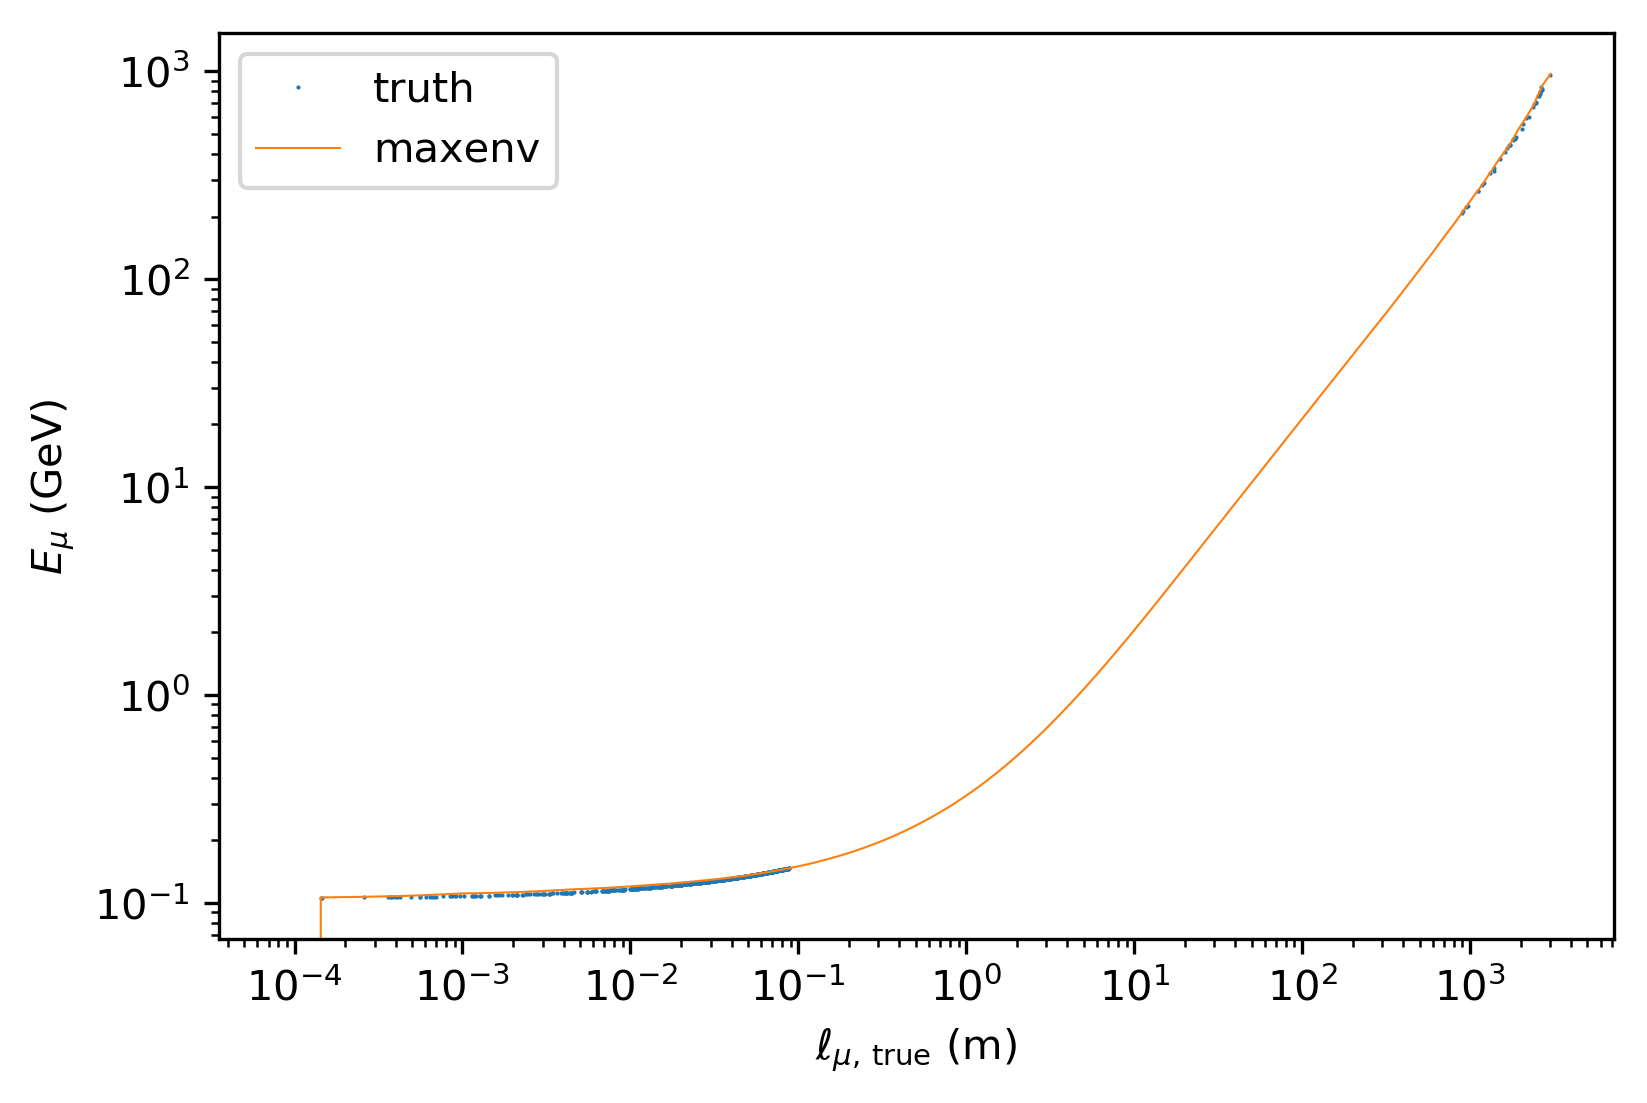

In [37]:
fig, ax = plt.subplots(dpi=300)
x = numu_cc.truth_highest_energy_daughter_length.values
sortind = np.argsort(x)
x = x[sortind]
maxenv_mu_en = numu_cc.maxenv_mu_en.values[sortind]
true_en = numu_cc.truth_highest_energy_daughter_energy.values[sortind]
mask =  maxenv_mu_en > true_en
print(np.sum(mask) / mask.size)
print(np.min(maxenv_mu_en / true_en))

ax.plot(x[mask], numu_cc.truth_highest_energy_daughter_energy.values[sortind][mask], 'o', ms=1, mec='none', mfc='C0', label='truth')
#ax.plot(numu_cc.truth_highest_energy_daughter_length.values[mask[sortind]], numu_cc.truth_highest_energy_daughter_energy.values[mask[sortind]], 'o', ms=0.5, mec='none', mfc='C0', label='truth')
ax.plot(x, numu_cc.maxenv_mu_en.values[sortind], '-', lw=0.5, label='maxenv')
#ax.plot(x, numu_cc.table_mu_en.values[sortind], '-', lw=0.5, label='table')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlabel(r'$\ell_{\mu,\,{\rm true}}$ (m)')
ax.set_ylabel(r'$E_{\mu}$ (GeV)')
pass

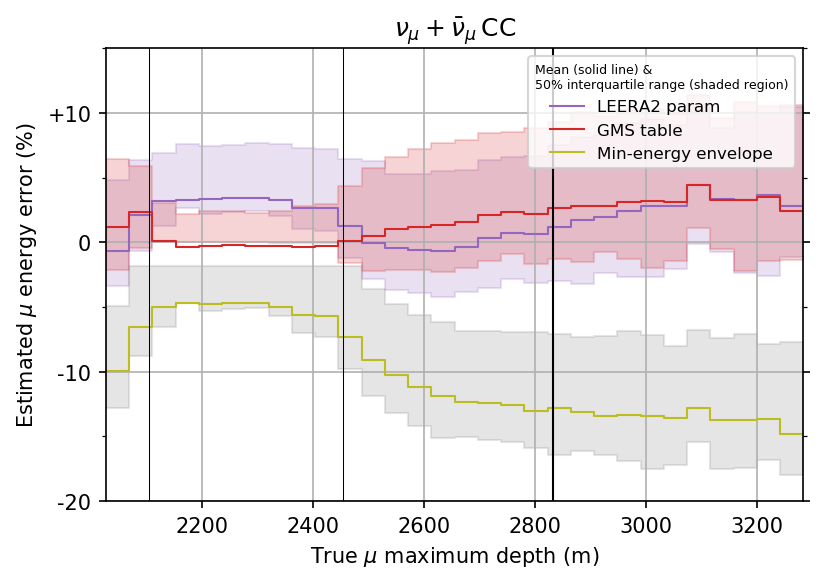

In [38]:
for name, evts in flavgroups.items():
    if 'numu' not in name:
        continue
    #bin_col = "truth_z"
    #xlabel = r'True $\mu$ vertex, z coordinate (m)'
    bin_col = "truth_highest_energy_daughter_max_depth"
    xlabel = r'True $\mu$ maximum depth (m)'

    lim = tuple(evts[bin_col].quantile(q=(0.0001, 0.999)))
    bin_edges = np.linspace(lim[0], lim[1], 31)

    fig, ax = plt.subplots(1, 1, dpi=150)
    ylim = 0.8, 1.15
    ax = plot_est_mu_en_error(
        evts=evts,
        name=name,
        bin_edges=bin_edges,
        bin_col=bin_col,
        solid='mean',
        ax=ax,
        ylim=ylim,
        plot_constant=False,
        plot_mmc3=False,
        plot_mmc4=False,
        plot_leera2=True,
        plot_proposal=False,
        plot_table=True,
        plot_ionization=False,
        plot_min_en_env=True,
    )
    ylim = ax.get_ylim()
    ax.plot([BEDROCK_DEPTH]*2, ylim, 'k-', lw=1, label='Top of bedrock')
    ax.plot([I3_Z0_DEPTH - dc_sd_zlims[0]]*2, ylim, 'k-', lw=0.5, label='DeepCore sub-dust DOM depths')
    ax.plot([I3_Z0_DEPTH - dc_sd_zlims[1]]*2, ylim, 'k-', lw=0.5)
    ax.set_xlabel(xlabel)
    ax.set_xscale('linear')
    leg = ax.get_legend()
    ax.set_xlim(lim)
    fig = ax.get_figure()
    fname = join(outdir, 'muon_energy_err_vs_true_muon_length_{}'.format(name))
    fig.savefig(fname + '.png', dpi=120)
    fig.savefig(fname + '.pdf')

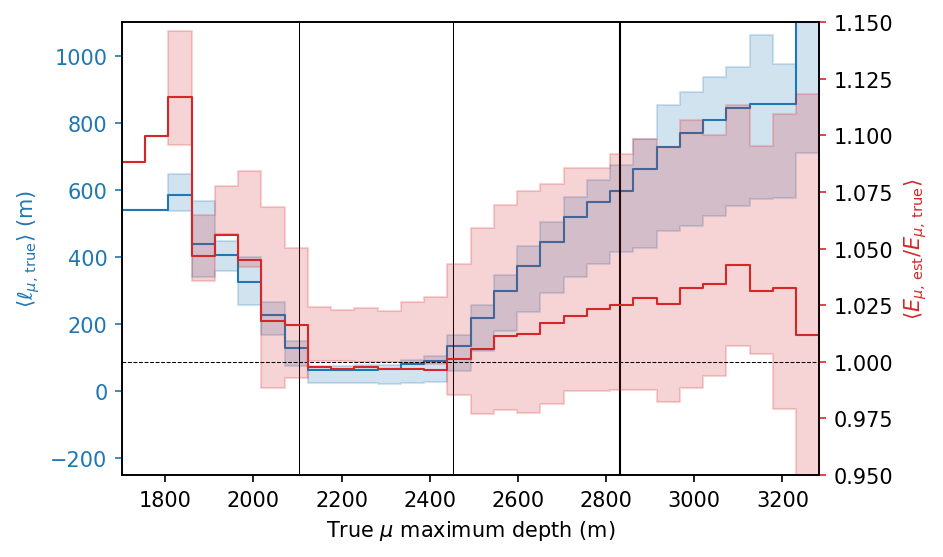

In [39]:
for name, evts in flavgroups.items():
    if 'numu' not in name:
        continue

    bin_col = "truth_highest_energy_daughter_max_depth"
    xlabel = r'True $\mu$ maximum depth (m)'

    lim = tuple(evts[bin_col].quantile(q=(0.0000, 0.999)))
    bin_edges = np.linspace(lim[0], lim[1], 31)

    kw = dict(q=(0.25, 0.75))
    avg_mu_len = binned_op(evts=evts, bin_col=bin_col, bin_edges=bin_edges, op_col=true_mu_len_col, op=q0_mean_q1, op_kwargs=kw)
    avg_mu_enerr = binned_op(evts=evts, bin_col=bin_col, bin_edges=bin_edges, op_col="table_mu_en_rat", op=q0_mean_q1, op_kwargs=kw)

    alpha = 0.2

    fig, ax1 = plt.subplots(1, 1, dpi=150)
    ax = ax1
    y = avg_mu_len
    c = 'C0'
    ax.fill_between(
        x=bin_edges,
        y1=[y[0, 0]] + y[:, 0].tolist(),
        y2=[y[0, 0]] + y[:, 2].tolist(),
        step='pre',
        color=hsvaFact(c, af=alpha),
    )
    ax.step(
        bin_edges,
        [y[0, 1]] + y[:, 1].tolist(),
        #label='PROPOSAL param',
        lw=1,
        color=c,
    )
    ylim2 = -250, 1100 #ax.get_ylim()
    ax.plot([BEDROCK_DEPTH]*2, ylim2, 'k-', lw=1, label='Top of bedrock')
    ax.plot([I3_Z0_DEPTH - dc_sd_zlims[0]]*2, ylim2, 'k-', lw=0.5, label='DeepCore sub-dust DOM depths')
    ax.plot([I3_Z0_DEPTH - dc_sd_zlims[1]]*2, ylim2, 'k-', lw=0.5)
    #ax.step(zbin_edges, [avg_mu_len[0]] + avg_mu_len.tolist(), '-', c='C0', lw=1, label='vertex z coord (m)')
    ax.set_ylabel(r'$\langle \ell_{\mu, \, {\rm true}} \rangle$ (m)', color='C0')
    #ax.legend(loc='upper right')
    ax.tick_params('y', colors='C0')
    ax.set_xlabel(xlabel)
    ax.set_xlim(lim)
    ax.set_ylim(ylim2)
    
    ax2 = ax1.twinx()
    ax = ax2
    ax.plot(lim, [1,1], 'k--', lw=0.5)
    y = avg_mu_enerr
    ylim = 0.95, 1.15
    c = 'C3'
    ax.fill_between(
        x=bin_edges,
        y1=[y[0, 0]] + y[:, 0].tolist(),
        y2=[y[0, 0]] + y[:, 2].tolist(),
        step='pre',
        color=hsvaFact(c, af=alpha),
    )
    ax.step(
        bin_edges,
        [y[0, 1]] + y[:, 1].tolist(),
        #label='PROPOSAL param',
        lw=1,
        color=c,
    )
    ax.set_ylim(ylim)
    #ax.step(zbin_edges, [avg_mu_enerr[0]] + avg_mu_enerr.tolist(), '-', c='C1', lw=1, label='est energy / true energy')
    ax.set_ylabel(r'$\langle E_{\mu,\,{\rm est}} / E_{\mu, \, {\rm true}} \rangle$', color=c)
    ax.tick_params('y', color=c)
    ax.tick_params('yticklabels', color=c)
    #ax.set_yticklabels
    ax.set_xlim(lim)
    #ax.legend(loc='lower right')
    

# Estimated $\nu$ energy error vs. true $\nu$ energy

Suppose that we estimated cascade energy and track length perfectly, then what will the error be in estimated $\nu$ energy using

$$E_\nu = E_{\rm cascade} + f(\ell_\mu)$$

nue_cc+nuebar_cc
numu_cc+numubar_cc
nutau_cc+nutaubar_cc
nuall_nc+nuallbar_nc


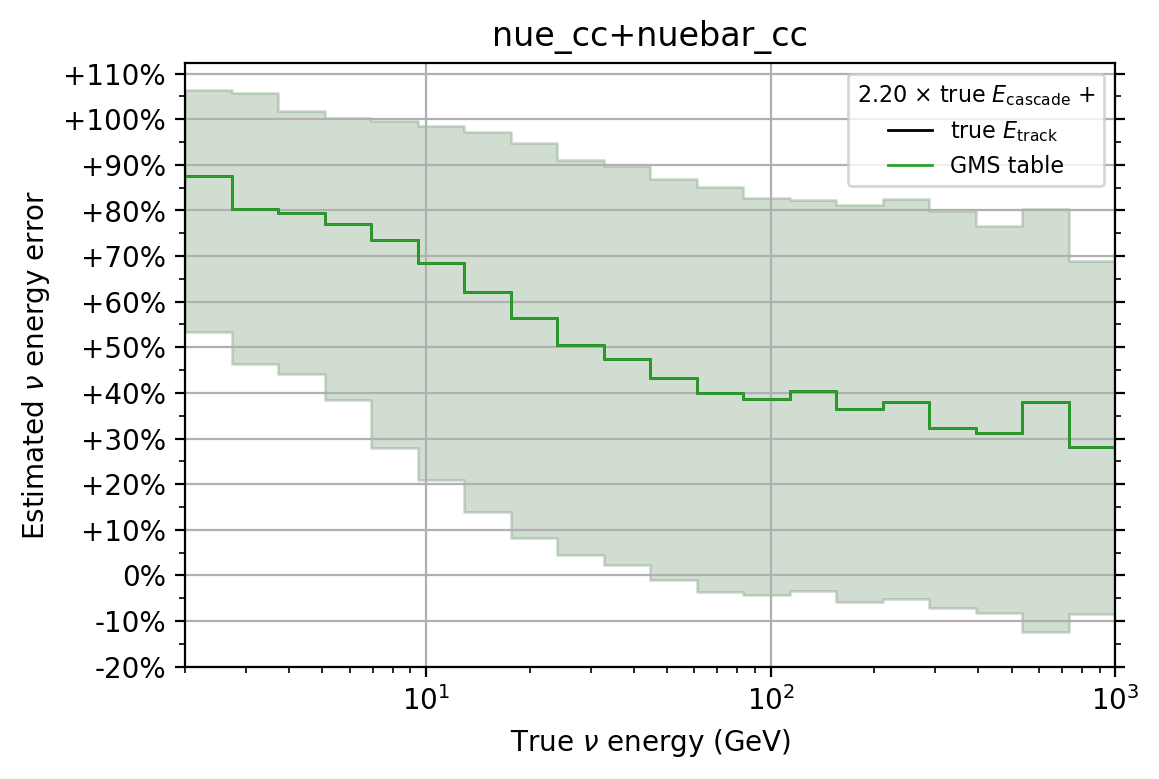

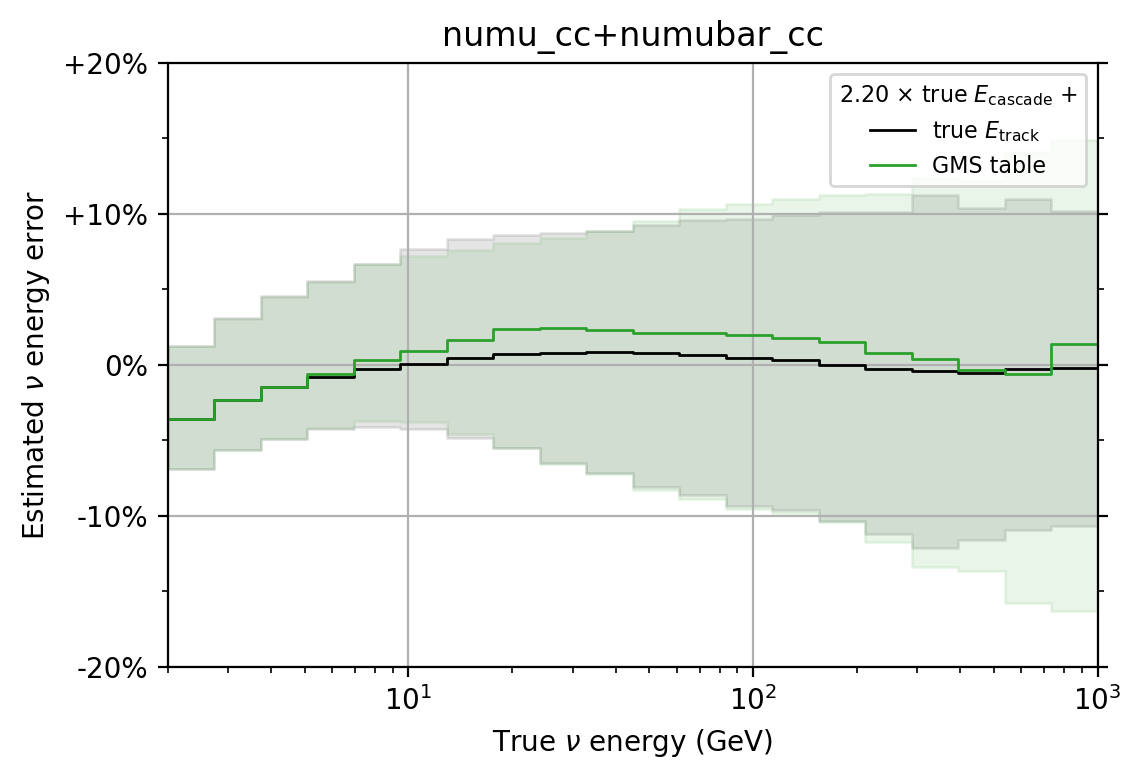

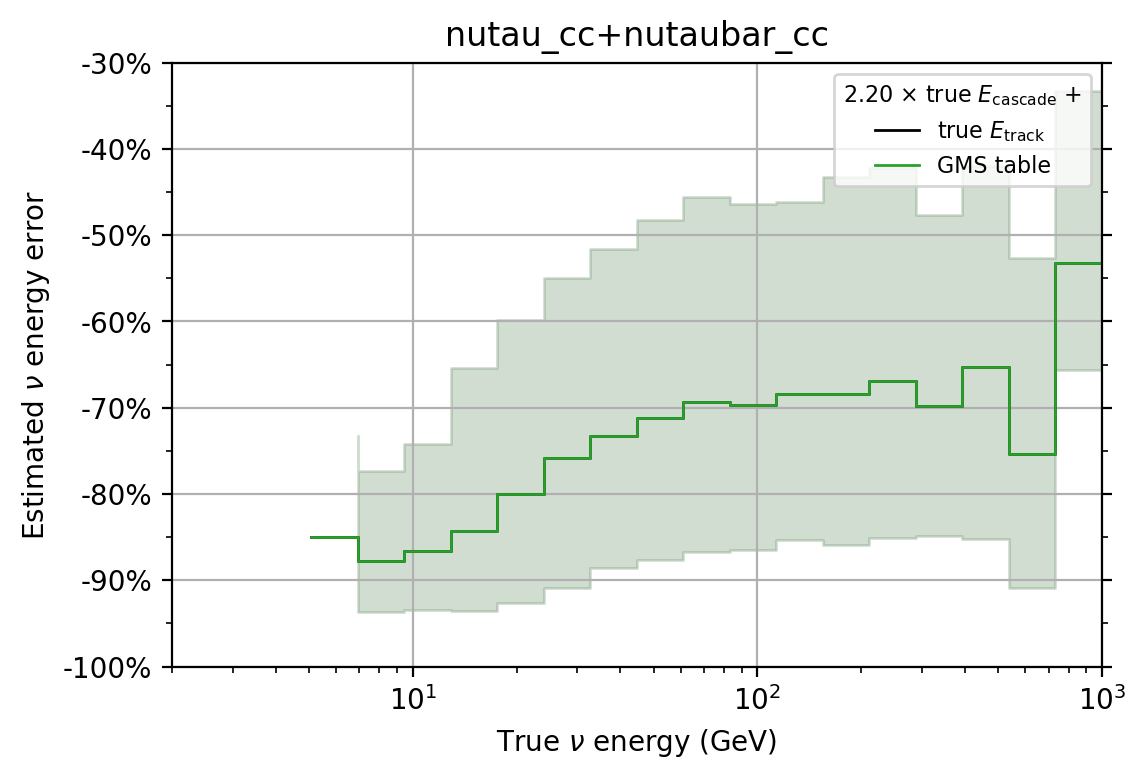

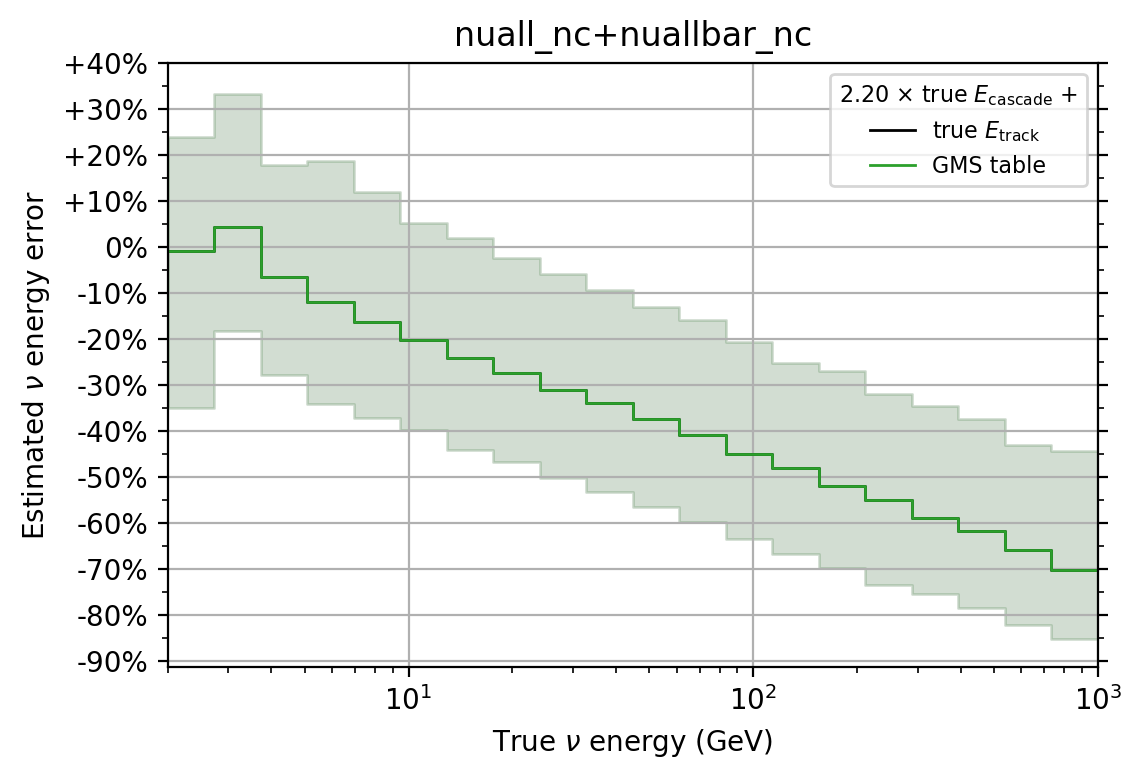

In [40]:
fact = 2.2

#name = "nue_cc+nuebar_cc"
#evts = flavgroups[name]
for name, evts in flavgroups.items():
    print(name)
    if len(evts) == 0:
        print(name, 'failed')
        continue
    cscd_en = evts.truth_cascade_energy * fact
    true_mu_energy = evts.truth_highest_energy_daughter_energy if "numu_cc" in name else 0
    true_nu_energy = evts.truth_energy
    mmc_energy = evts.mmc3_mu_en
    const_energy = evts.const_mu_en
    table_energy = evts.table_mu_en

    truth_e_err_rat = (cscd_en + true_mu_energy) / true_nu_energy
    mmc_e_err_rat = (cscd_en + mmc_energy) / true_nu_energy
    const_e_err_rat = (cscd_en + const_energy) / true_nu_energy
    table_e_err_rat = (cscd_en + table_energy) / true_nu_energy

    tebins = np.logspace(np.log10(2), np.log10(1e3), 21)
    tebin_indices = np.digitize(true_nu_energy, bins=tebins)

    def op(x):
        return np.percentile(x, [25, 50, 75])

    be_truth = []
    be_mmc = []
    be_const = []
    be_table = []
    for idx in range(len(tebins) - 1):
        mask = tebin_indices == idx
        if np.sum(mask) > 0:
            be_truth.append(op(truth_e_err_rat[mask]))
            be_mmc.append(op(mmc_e_err_rat[mask]))
            be_const.append(op(const_e_err_rat[mask]))
            be_table.append(op(table_e_err_rat[mask]))
        else:
            x = [np.nan]*3
            be_truth.append(x)
            be_mmc.append(x)
            be_const.append(x)
            be_table.append(x)

    be_truth = np.array(be_truth)
    be_mmc = np.array(be_mmc)
    be_const = np.array(be_const)
    be_table = np.array(be_table)


    # -- Plot it! -- #

    fig, ax = plt.subplots(dpi=200)

    xlim = 2, 1000
    ylim = 0.2, 2.3
    alpha = 0.1

    ax.fill_between(x=tebins, y1=[be_truth[0, 0]] + be_truth[:, 0].tolist(), y2=[be_truth[0, 0]] + be_truth[:, 2].tolist(), step='pre', color=hsvaFact('k', af=alpha))
    ax.step(tebins, [be_truth[0, 1]] + be_truth[:, 1].tolist(), label=r'true $E_{\rm track}$', lw=1, color='k')

    #ax.fill_between(x=tebins, y1=[be_const[0, 0]] + be_const[:, 0].tolist(), y2=[be_const[0, 0]] + be_const[:, 2].tolist(), step='pre', color=hsvaFact('C0', af=alpha))
    #ax.step(tebins, [be_const[0, 1]] + be_const[:, 1].tolist(), label='constant ~{:.3f} m/GeV'.format(TRACK_M_PER_GEV), lw=1, color='C0')

    #ax.fill_between(x=tebins, y1=[be_mmc[0, 0]] + be_mmc[:, 0].tolist(), y2=[be_mmc[0, 0]] + be_mmc[:, 2].tolist(), step='pre', color=hsvaFact('C1', af=alpha))
    #ax.step(tebins, [be_mmc[0, 1]] + be_mmc[:, 1].tolist(), label='MMC param', lw=1, color='C1')

    ax.fill_between(x=tebins, y1=[be_table[0, 0]] + be_table[:, 0].tolist(), y2=[be_table[0, 0]] + be_table[:, 2].tolist(), step='pre', color=hsvaFact('C2', af=alpha))
    ax.step(tebins, [be_table[0, 1]] + be_table[:, 1].tolist(), label='GMS table', lw=1, color='C2')

    #ax.step(tebins, [be_mmc[0]] + be_mmc, label='MMC')
    #ax.step(tebins, [be_table[0]] + be_table, label='table')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_ylim(ylim)
    actual_ylim = np.round(ax.get_ylim(), 1)
    yticks = np.arange(actual_ylim[0], actual_ylim[1]+0.01, 0.1)
    ax.set_yticks(yticks)
    ax.set_yticks(np.arange(actual_ylim[0] + .05, actual_ylim[1] - 0.05 + .001, 0.1), minor=True)
    ax.set_yticklabels(["{:+d}%".format(int(np.round(100*(y-1)))).replace("+0", "0") for y in yticks])
    ax.grid(True)
    ax.set_xlim(xlim)
    ax.yaxis.set_ticks_position('both')
    ax.set_title(name)

    leg = ax.legend(loc='best', fontsize=8, title=r'{:.2f} $\times$ true $E_{{\rm cascade}}$ +'.format(fact))
    leg.get_title().set_fontsize(8)

    ax.set_xlabel(r'True $\nu$ energy (GeV)')
    ax.set_ylabel(r'Estimated $\nu$ energy error')

    fpath = join(outdir, 'est_nu_energy_binned_ratio_error_{}'.format(name))
    # fig.savefig(fpath + '.png', dpi=300)
    # fig.savefig(fpath + '.pdf')
pass

# Validate table results

In [41]:
table = np.loadtxt("../data/muon_stopping_power_and_range_table_II-28.csv", delimiter=',')

In [42]:
kinetic_energy = table[:, 0]
total_energy = MUON_REST_MASS + kinetic_energy
stopping_power = table[:, 6] * 100 / 1000 * NOMINAL_ICE_DENSITY
spl = UnivariateSpline(x=total_energy, y=1/stopping_power, s=0, k=3)
energies = np.logspace(np.log10(total_energy[0]), np.log10(total_energy[-1]), 1000)
#energies = np.linspace(total_energy[0], total_energy[-1], 1000)
r = np.array([spl.integral(total_energy[0], e) for e in energies])

In [43]:
table.shape

(45, 8)

In [44]:
table

array([[1.00000e-02, 4.70400e+01, 7.96500e+00,         nan,         nan,         nan, 7.96500e+00, 7.03000e-01],
       [1.40000e-02, 5.61600e+01, 6.21300e+00,         nan,         nan,         nan, 6.21300e+00, 1.27800e+00],
       [2.00000e-02, 6.80200e+01, 4.85200e+00,         nan,         nan,         nan, 4.85200e+00, 2.38300e+00],
       [3.00000e-02, 8.50900e+01, 3.76400e+00,         nan,         nan,         nan, 3.76400e+00, 4.75600e+00],
       [4.00000e-02, 1.00300e+02, 3.21400e+00,         nan,         nan,         nan, 3.21400e+00, 7.64900e+00],
       [8.00000e-02, 1.52700e+02, 2.41300e+00,         nan,         nan,         nan, 2.41300e+00, 2.24700e+01],
       [1.00000e-01, 1.76400e+02, 2.27000e+00,         nan,         nan,         nan, 2.27000e+00, 3.10400e+01],
       [1.40000e-01, 2.21800e+02, 2.11600e+00,         nan,         nan,         nan, 2.11600e+00, 4.93700e+01],
       [2.00000e-01, 2.86800e+02, 2.02600e+00,         nan,         nan,         nan, 2.02600e+0

In [45]:
other = np.atleast_2d(table[:, 6] - np.nansum([table[:, i] for i in range(2, 6)], axis=0)).T
other

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.00000000e-03],
       [ 1.00000000e-03],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 4.44089210e-16],
       [ 0.00000000e+00],
       [ 1.00000000e-03],
       [ 1.00000000e-03],
       [ 4.44089210e-16],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.00000000e-03],
       [-1.00000000e-03],
       [ 1.00000000e-03],
       [ 1.00000000e-03],
       [-1.00000000e-03],
       [ 1.00000000e-03],
       [ 1.00000000e-03],
       [-8.88178420e-16],
       [-1.00000000e-03],
       [ 1.00000000e-03],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.00000000e-03],
       [ 1.0

In [46]:
print(other.max())
wh = np.where(other == other.max())[0]
print(table[wh, :])

0.0010000000000047748
[[8.00000e+03 8.00000e+06 3.30700e+00 9.33800e+00 1.31940e+01 3.76300e+00 2.96030e+01 7.17900e+05]
 [1.00000e+04 1.00000e+07 3.33500e+00 1.17660e+01 1.65870e+01 4.77300e+00 3.64620e+01 7.78700e+05]
 [4.00000e+04 4.00000e+07 3.51700e+00 4.84240e+01 6.75300e+01 2.12960e+01 1.40768e+02 1.16800e+06]]


In [47]:
print(other.min())
wh = np.where(other == other.min())[0]
print(table[wh, :])

-0.001000000000000334
[[1.400e+02 1.401e+05 2.831e+00 1.160e-01 1.610e-01 5.900e-02 3.166e+00 4.922e+04]]


In [48]:
3.613 + 97.657 + 135.668 + 45.199

282.137

In [49]:
np.array([table[:, i] for i in range(2, 7)]).T

array([[7.96500e+00,         nan,         nan,         nan, 7.96500e+00],
       [6.21300e+00,         nan,         nan,         nan, 6.21300e+00],
       [4.85200e+00,         nan,         nan,         nan, 4.85200e+00],
       [3.76400e+00,         nan,         nan,         nan, 3.76400e+00],
       [3.21400e+00,         nan,         nan,         nan, 3.21400e+00],
       [2.41300e+00,         nan,         nan,         nan, 2.41300e+00],
       [2.27000e+00,         nan,         nan,         nan, 2.27000e+00],
       [2.11600e+00,         nan,         nan,         nan, 2.11600e+00],
       [2.02600e+00,         nan,         nan,         nan, 2.02600e+00],
       [1.99200e+00,         nan,         nan, 0.00000e+00, 1.99200e+00],
       [1.99200e+00,         nan,         nan, 0.00000e+00, 1.99200e+00],
       [1.99800e+00,         nan,         nan, 0.00000e+00, 1.99900e+00],
       [2.07400e+00, 0.00000e+00,         nan, 0.00000e+00, 2.07500e+00],
       [2.10900e+00, 0.00000e+00,     

In [50]:
csda_range = table[:, 7] / NOMINAL_ICE_DENSITY / 100

In [51]:
# 1 g / cm^3 * kg_per_g
cm_per_m = 1e2
kg_per_g = 1e-3
1 * kg_per_g * cm_per_m**3

1000.0

In [52]:
energies.max()

100000.10565836992

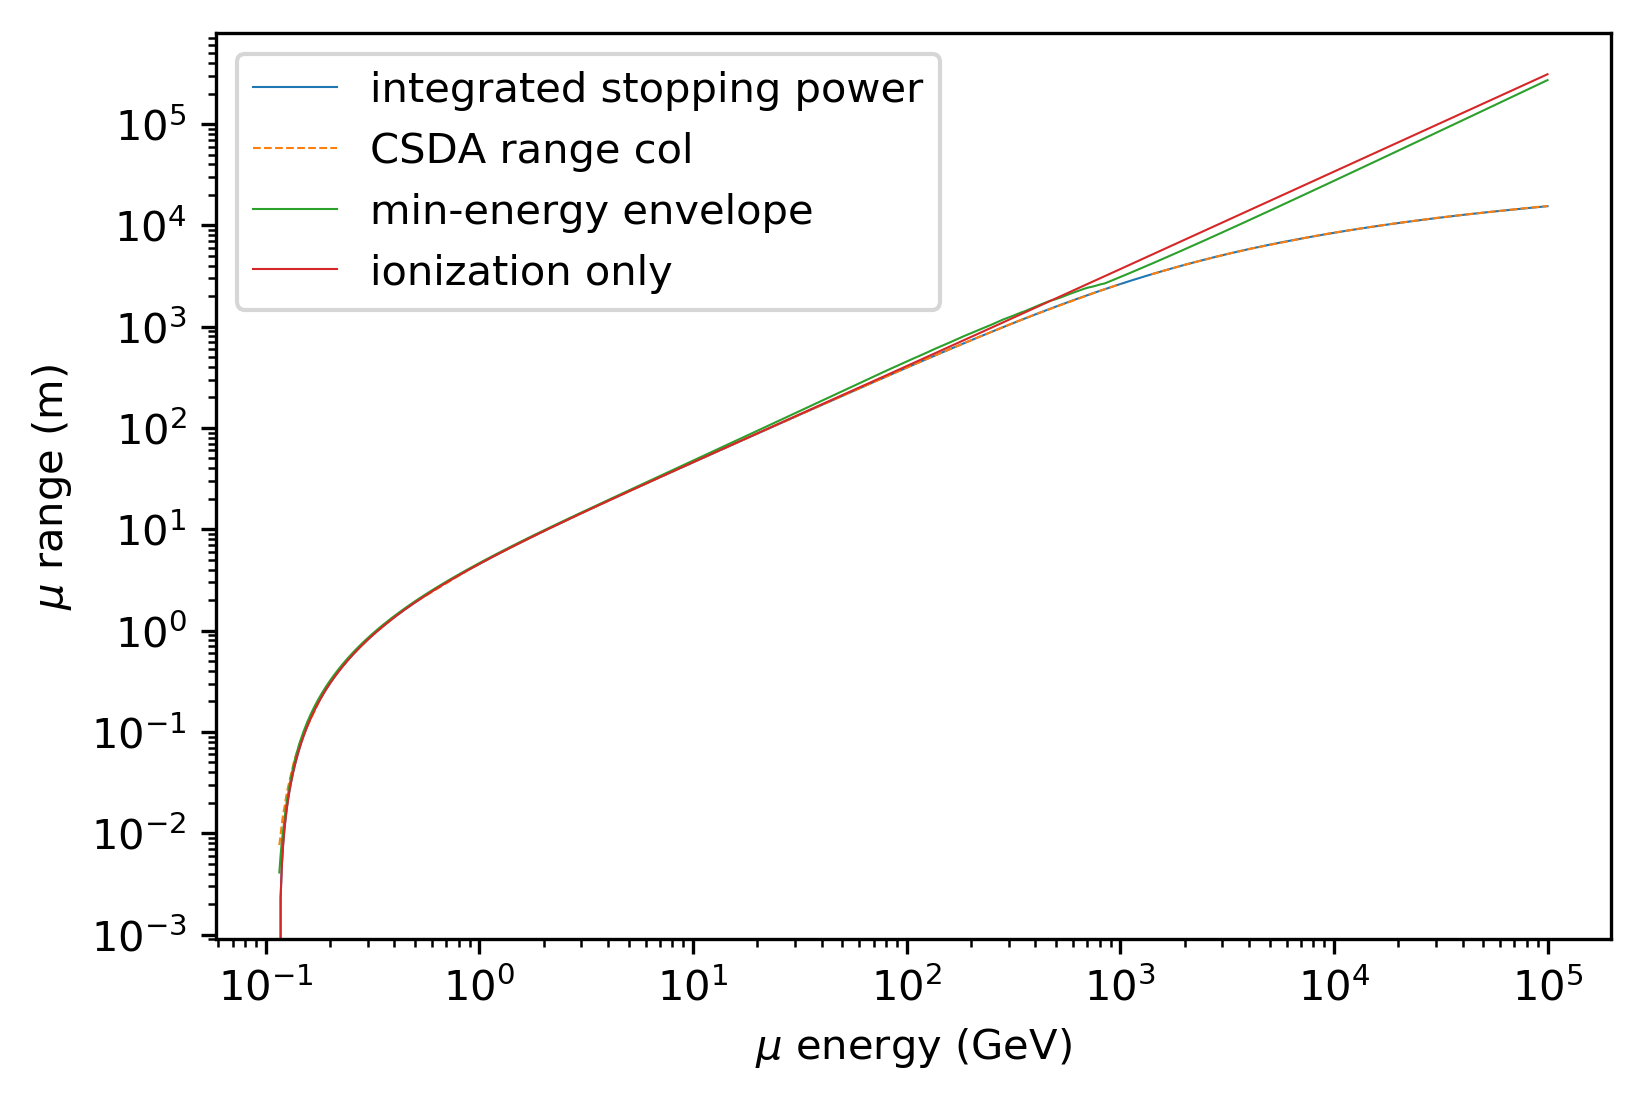

In [53]:
fig, ax = plt.subplots(dpi=300)
ax.plot(energies, r, lw=0.5, label='integrated stopping power')
ax.plot(total_energy, csda_range, ls='--', lw=0.5, label='CSDA range col')
ax.plot(energies, maxenv_muon_energy_to_length(energies), lw=0.5, ls='-', label='min-energy envelope')
ax.plot(energies, ionization_muon_energy_to_length(energies), lw=0.5, ls='-', label='ionization only')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlabel(r'$\mu$ energy (GeV)')
ax.set_ylabel(r'$\mu$ range (m)')
pass